### Homework part II: experience replay
_This notebook builds upon `qlearning.ipynb`, or to be exact, generating qlearning.py._

There's a powerful technique that you can use to improve sample efficiency for off-policy algorithms: [spoiler] Experience replay :)

The catch is that you can train Q-learning and EV-SARSA on `<s,a,r,s'>` tuples even if they aren't sampled under current agent's policy. So here's what we're gonna do:

<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/exp_replay.png width=480>

#### Training with experience replay
1. Play game, sample `<s,a,r,s'>`.
2. Update q-values based on `<s,a,r,s'>`.
3. Store `<s,a,r,s'>` transition in a buffer. 
 3. If buffer is full, delete earliest data.
4. Sample K such transitions from that buffer and update q-values based on them.


To enable such training, first we must implement a memory structure that would act like such a buffer.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

from qlearning import QLearningAgent, ReplayBuffer, play_and_train_with_replay

#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1
        
%load_ext autoreload
%autoreload 2

Some tests to make sure your buffer works right

In [2]:
replay = ReplayBuffer(2)
obj1 = tuple(range(5))
obj2 = tuple(range(5, 10))
replay.add(*obj1)
assert replay.sample(1)==obj1, "If there's just one object in buffer, it must be retrieved by buf.sample(1)"
replay.add(*obj2)
assert len(replay._storage)==2, "Please make sure __len__ methods works as intended."
replay.add(*obj2)
assert len(replay._storage)==2, "When buffer is at max capacity, replace objects instead of adding new ones."
assert tuple(np.unique(a) for a in replay.sample(100))==obj2
replay.add(*obj1)
assert max(len(np.unique(a)) for a in replay.sample(100))==2
replay.add(*obj1)
assert tuple(np.unique(a) for a in replay.sample(100))==obj1
print ("Success!")

Success!


Now let's use this buffer to improve training:

In [3]:
import gym

env = gym.make("Taxi-v2")
n_actions = env.action_space.n

In [4]:
# Create two agents: first will use experience replay, second will not.

agent_baseline = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                       get_legal_actions = lambda s: range(n_actions))

agent_replay = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                       get_legal_actions = lambda s: range(n_actions))

replay = ReplayBuffer(1000)

Baseline : eps = 2.9191091959171894e-05 mean reward = 7.3
ExpReplay: eps = 2.9191091959171894e-05 mean reward = 11.0


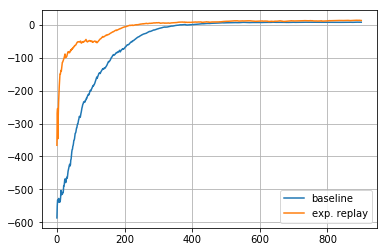

In [5]:
from IPython.display import clear_output
from pandas import DataFrame
moving_average = lambda x, span=100: DataFrame({'x': np.asarray(x)}).x.ewm(span=span).mean().values

rewards_replay, rewards_baseline = [], []

for i in range(1000):
    rewards_replay.append(play_and_train_with_replay(env, agent_replay, replay))
    rewards_baseline.append(play_and_train_with_replay(env, agent_baseline, replay=None))
    
    agent_replay.epsilon *= 0.99
    agent_baseline.epsilon *= 0.99
    
    if i %100 ==0:
        clear_output(True)
        print('Baseline : eps =', agent_baseline.epsilon, 'mean reward =', np.mean(rewards_baseline[-10:]))
        print('ExpReplay: eps =', agent_replay.epsilon, 'mean reward =', np.mean(rewards_replay[-10:]))
        plt.plot(moving_average(rewards_baseline), label='baseline')
        plt.plot(moving_average(rewards_replay), label='exp. replay')
        plt.grid()
        plt.legend()
        plt.show()

### Submit to Coursera

In [ ]:
# from submit import submit_experience_replay

# submit_experience_replay(rewards_replay, rewards_baseline, <EMAIL>, <TOKEN>)

#### What to expect:

Experience replay, if implemented correctly, will improve algorithm's initial convergence a lot, but it shouldn't affect the final performance.

### Outro

We will use the code you just wrote extensively in the next week of our course. If you're feeling that you need more examples to understand how experience replay works, try using it for binarized state spaces (CartPole or other __[classic control envs](https://gym.openai.com/envs/#classic_control)__).

__Next week__ we're gonna explore how q-learning and similar algorithms can be applied for large state spaces, with deep learning models to approximate the Q function.

However, __the code you've written__ for this week is already capable of solving many RL problems, and as an added benifit - it is very easy to detach. You can use Q-learning, SARSA and Experience Replay for any RL problems you want to solve - just thow 'em into a file and import the stuff you need.